# Link between free space and 3-point efficiency

After modelling both model of space occupation and comparing them, we focus on the correlation between space occupation and 3-point performance. To do so, we browse all the games we have, we track when there are 3-point shots and then memorize the evolution of pressure on the shooter 3 seconds before he shots. The algorithm is not presented here, but is available as a python file : track_shoot.py.

Here we extract the informations we want from the data we collected. 

## Data import
-----

The shots are memorized in two csv files : df_plot_mean and df_shots calculated thanks to python_file shots_statistics.py. They contain the same information but aren't structured in the same way (df_plot_mean's structure let us plot averaged evolution). They are composed of the following columns :
* D : evolution of the shooter's *free space* ($\delta_{space}^*$ distance to the closest defender) 3 seconds before the shot. 
* T : It the same but *free space* is calculated as the time (in second) needed by the closest defender to join the position of the shooter ($\delta_{time}^*$). 
* Release time : corresponds to the time between the reception of the ball and the shot. It is negative : -2 means that the shooter kept the ball 2 seconds before shooting.
* Time : corresponds to time values linked to free space evolution.
* player_id : a list which contains shooters' ID.
* x_shot,y_shot : position of the player at the release.
* x_ball, y_ball, z_ball : ball's trajectory.
* quarter,clock,Match_id
* Shot_type : type of shots (catch-and-shoot or pull-up)
* Shot_result : differentiate hits or miss


In [1]:
import pandas as pd
import ast

df_plot_mean=pd.read_csv('data/df_plot_mean.csv',index_col=[0])
df_shots=pd.read_csv('data/df_shots.csv',index_col=[0],converters={1:ast.literal_eval,2:ast.literal_eval,3:ast.literal_eval,7:ast.literal_eval,8:ast.literal_eval,9:ast.literal_eval,18:ast.literal_eval,19:ast.literal_eval,20:ast.literal_eval})
df_stats=pd.read_csv('data/df_stats.csv',index_col=[0])

/Users/gabin/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/arraysetops.py:568: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [2]:
info_players=pd.read_csv('data/players.csv',index_col=[0])

In [3]:
print('number of shots:',len(df_shots))
print(df_stats['total_cas'].sum(),df_stats['total_cas'].sum()/26295*100)
print(df_stats['success'].sum(),df_stats['miss'].sum(),df_stats['success'].sum()/26295*100)
print(df_stats['success_cas'].sum(),df_stats['miss_cas'].sum(),df_stats['success_cas'].sum()/18896*100)
print(len(df_shots.query('Shot_type=="pull-up 3P" and Shot_result==1'))/len(df_shots.query('Shot_type=="pull-up 3P"')))

number of shots: 26332
18916 71.93763072827534
9136 17196 34.74424795588515
6803 12113 36.00232853513971
0.3145900755124056


## *Free space* evolution before a 3-point shot
------

### Plot all shots

In [4]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

(0, 30)

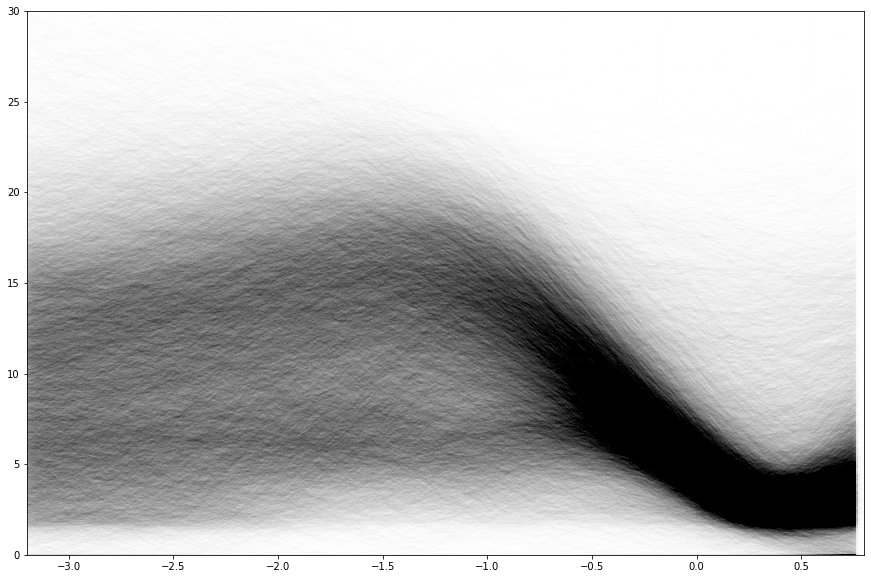

In [39]:
fig=plt.figure(figsize=(15,10))
for row in df_shots.itertuples():
    Time=getattr(row,'Time')
    D=getattr(row,'D')
    plt.plot(Time,D,'k-',alpha=0.005)
plt.xlim((-3.2,0.8))
plt.ylim((0,30))

### Mean evolution

First we compute a function to plot the evolution of *free space* averaged on all the shots. Let's note that we round the values of time with a precision of 0.01 second. Yet the precision of position data is only 0.04 seconds. 

Let's note that we delet some shots because the values of time are wrong : the clock stops but the evolution continue to be captured therefore, if we don't do that, we have false values for a certain value of time.

In [9]:
def averaged_evolution(df,sd=None,hue=None,palette=['blue'],style=None,fontsize='medium',size=None):
    
    ## rename columns to have good labels ##
    df2=df.rename(columns={"Time": "time [s]",'D':r'$<\delta_{d}^*(t)$> [feet]','T':r'$<\delta_{t}^*(t)$> [s]'})
    
    ### plot ###
    ax = sns.lineplot(x="time [s]", y=r'$<\delta_{d}^*(t)$> [feet]', data=df2,palette=palette,ci=sd,hue=hue,style=style,size=size)
    plt.axvline(0, color='black',linestyle="dashed",lw=0.5)
    plt.legend(loc='lower left',fontsize=fontsize)
    plt.show()
    plt.clf()
   
    ax = sns.lineplot(x="time [s]", y=r'$<\delta_{t}^*(t)$> [s]', data=df2,palette=palette,ci=sd,hue=hue,style=style,size=size)
    plt.axvline(0, color='black',linestyle="dashed",lw=0.5)
    plt.legend(loc='lower left',fontsize=fontsize)
    plt.show()
    plt.clf()

In [10]:
df_plot_mean=df_plot_mean.query('Time>-3. and Time<0.8')

No handles with labels found to put in legend.


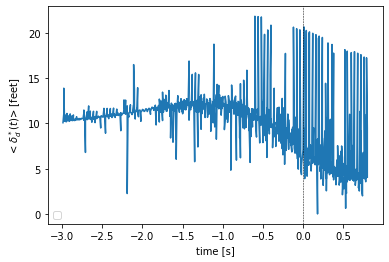

No handles with labels found to put in legend.


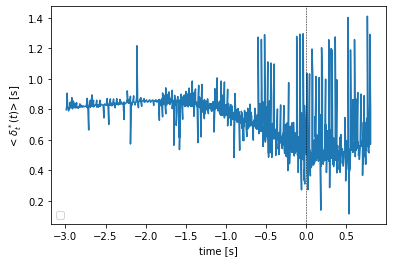

<Figure size 432x288 with 0 Axes>

In [7]:
averaged_evolution(df_plot_mean)

No handles with labels found to put in legend.


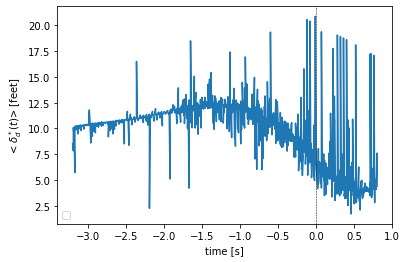

No handles with labels found to put in legend.


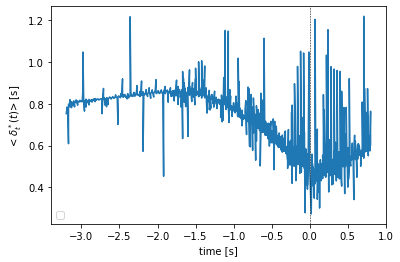

<Figure size 432x288 with 0 Axes>

In [6]:
averaged_evolution(df_plot_mean)

We see that there is some noise. To calculate the plot sns.lineplot take each value of time and make a mean over all the pressure value associated. If we count the number of pressure values per time value we can see that there isn't an equilibrium as there are more of multiple of 0.04 :

In [8]:
print('count',df_plot_mean.groupby('Time').count())

count           D     T  Time_to_shoot  Shot result  player_id  x_ball  y_ball  \
Time                                                                       
-3.20    50    50             50           50         50      50      50   
-3.19     1     1              1            1          1       1       1   
-3.19   141   141            141          141        141     141     141   
-3.18   189   189            189          189        189     189     189   
-3.17     3     3              3            3          3       3       3   
...     ...   ...            ...          ...        ...     ...     ...   
 0.79     3     3              3            3          3       3       3   
 0.79   677   677            677          677        677     677     677   
 0.79  1699  1699           1699         1699       1699    1699    1699   
 0.80     8     8              8            8          8       8       8   
 0.80  6238  6238           6238         6238       6238    6238    6238   

     

Our aim is to make mean for each value of time over the 26325 shots. To do so, we will aggregate values around multiple of 0.04 seconds with the following function :

In [11]:
def aggregating_04(row):
    number=row['Time']
    q=number//0.04
    if abs(round((q*0.04-number),2))<=0.02:
        return(q*0.04)
    else :
        return((q+1)*0.04)

In [12]:
df_plot_mean['Time']=df_plot_mean.apply(aggregating_04,axis=1)

No handles with labels found to put in legend.


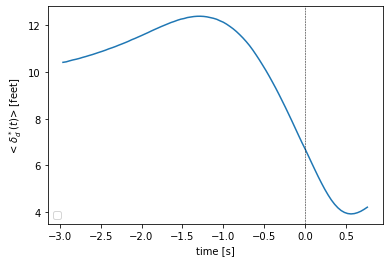

No handles with labels found to put in legend.


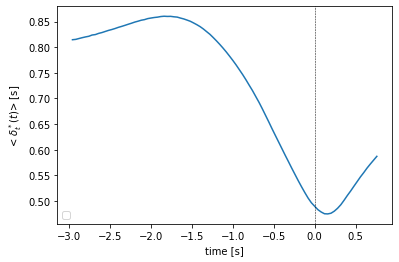

<Figure size 432x288 with 0 Axes>

In [17]:
averaged_evolution(df_plot_mean)

The result is better here. Now let's see if we plot the standard deviation :

No handles with labels found to put in legend.


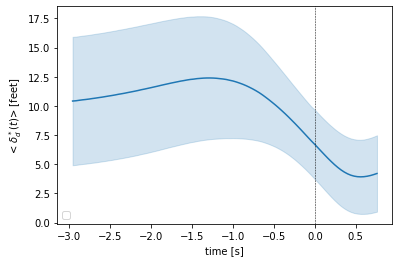

No handles with labels found to put in legend.


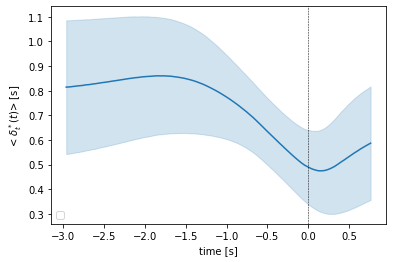

<Figure size 432x288 with 0 Axes>

In [18]:
averaged_evolution(df_plot_mean,sd='sd')

No handles with labels found to put in legend.


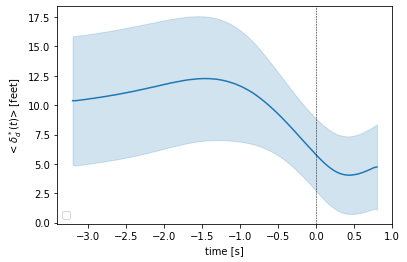

No handles with labels found to put in legend.


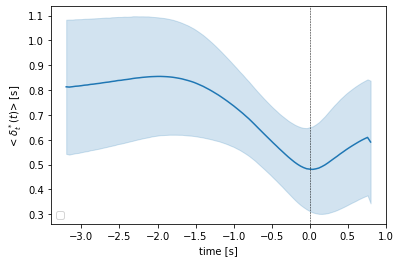

<Figure size 432x288 with 0 Axes>

In [9]:
averaged_evolution(df_plot_mean,sd='sd')

### Different types of shots

We distinguish two types of shots :
* catch-and-shoot shot : when a player immediately shot after receiving the ball (2 seconds after)
* pull-up shot : when a player shot after dribbling

In fact some shots can be in neither category : wait more than two seconds without dribbling. But we admit that this is only a small part of shots. Therefore to distinguish both types we look at the value TIME_TO_SHOOT.

We found that there were 78% of catch-and-shoot shots. Yet our games are from 2013 to 2016, according to https://www.thespax.com/nba/three-point-shooting-part-i-the-dying-catch-and-shoot-shot/, there were about 75% of catch-and-shoot shots. Our value is closed to the reality.

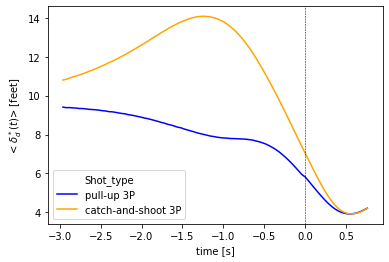

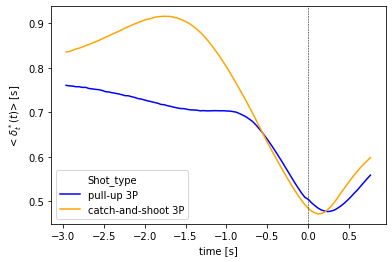

<Figure size 432x288 with 0 Axes>

In [19]:
averaged_evolution(df_plot_mean,palette=['blue','orange'],hue='Shot_type')

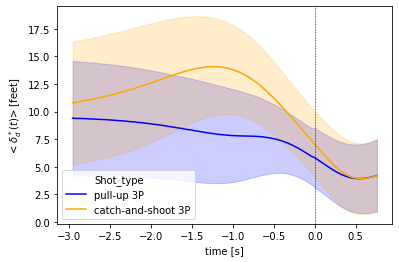

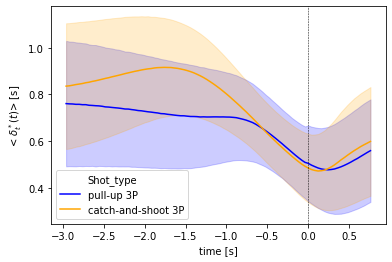

<Figure size 432x288 with 0 Axes>

In [21]:
averaged_evolution(df_plot_mean,palette=['blue','orange'],hue='Shot_type',sd='sd')

### Difference between success and miss

We want to know if the pressure exerced on a player has an influence on his 3-point performance.

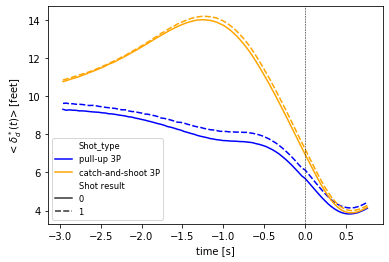

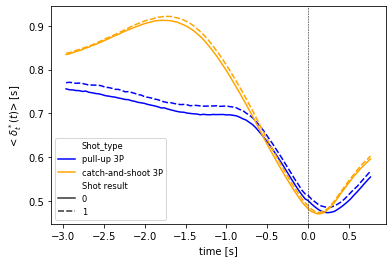

<Figure size 432x288 with 0 Axes>

In [22]:
averaged_evolution(df_plot_mean,palette=['blue','orange'],hue='Shot_type',style='Shot result',fontsize='small')

### Curry's case

No handles with labels found to put in legend.


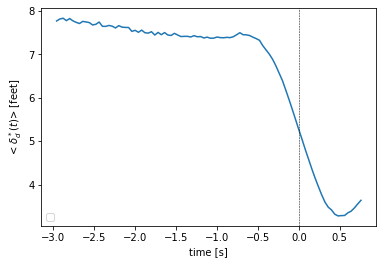

No handles with labels found to put in legend.


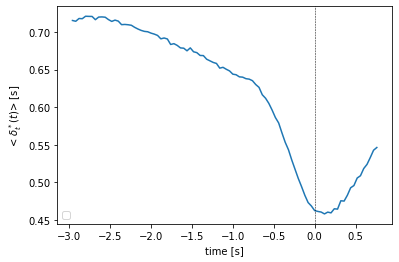

<Figure size 432x288 with 0 Axes>

In [23]:
df_curry_mean=df_plot_mean.query('player_id==201939').copy()
averaged_evolution(df_curry_mean)

No handles with labels found to put in legend.


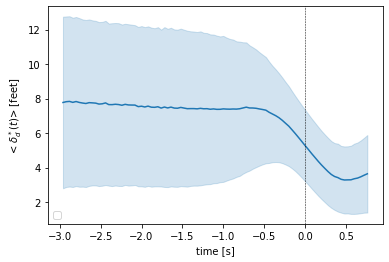

No handles with labels found to put in legend.


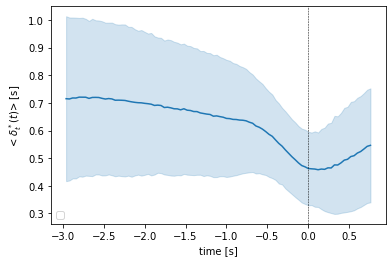

<Figure size 432x288 with 0 Axes>

In [24]:
averaged_evolution(df_curry_mean,sd='sd')

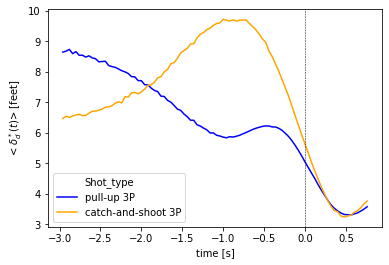

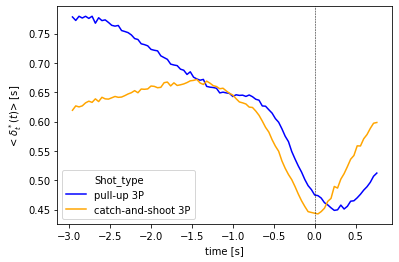

<Figure size 432x288 with 0 Axes>

In [25]:
averaged_evolution(df_curry_mean,palette=['blue','orange'],hue='Shot_type')

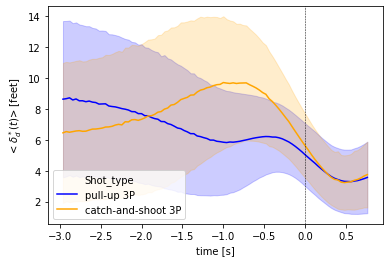

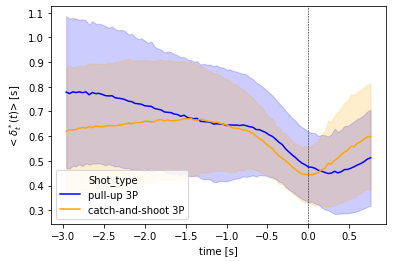

<Figure size 432x288 with 0 Axes>

In [27]:
averaged_evolution(df_curry_mean,palette=['blue','orange'],hue='Shot_type',sd='sd')

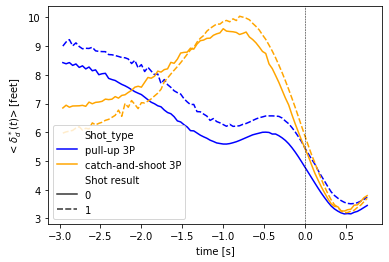

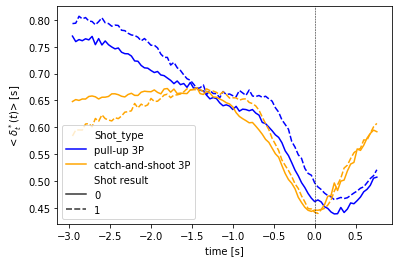

<Figure size 432x288 with 0 Axes>

In [28]:
averaged_evolution(df_curry_mean,palette=['blue','orange'],hue='Shot_type',style='Shot result')

### Compare Curry to global behaviour

In [29]:
def averaged_evolution_two_df(df,df_curry,sd=None,hue=None,palette=['blue'],style=None,size=None):
    
    ## rename columns to have good labels ##
    df2=pd.concat([df,df_curry],ignore_index=True)
    players=['all' for k in range(len(df))]+['Curry' for k in range(len(df_curry))]
    df2['Player']=players
    df2=df2.rename(columns={"Time": "time [s]",'D':r'$<\delta_{d}^*(t)$> [feet]','T':r'$<\delta_{t}^*(t)$> [s]'})
    
    ### plot ###
    ax = sns.lineplot(x="time [s]", y=r'$<\delta_{d}^*(t)$> [feet]', data=df2,palette=palette,ci=sd,hue=hue,style=style,size=size)
    plt.axvline(0, color='black',linestyle="dashed",lw=0.5)
    plt.legend(loc='lower left',fontsize='small')
    plt.show()
    plt.clf()
   
    ax = sns.lineplot(x="time [s]", y=r'$<\delta_{t}^*(t)$> [s]', data=df2,palette=palette,ci=sd,hue=hue,style=style,size=size)
    plt.axvline(0, color='black',linestyle="dashed",lw=0.5)
    plt.legend(loc='lower left',fontsize='small')
    #plt.savefig('Comparison_curry_t',dpi=72)
    plt.show()
    plt.clf()

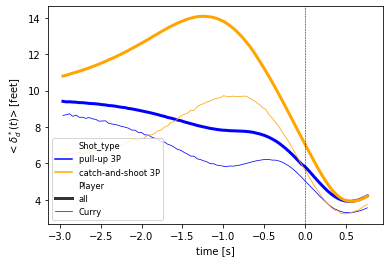

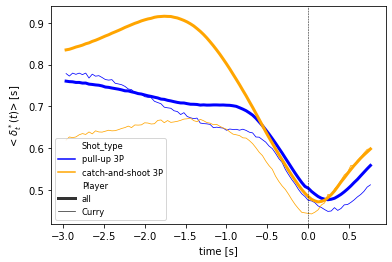

<Figure size 432x288 with 0 Axes>

In [31]:
averaged_evolution_two_df(df_plot_mean,df_curry_mean,sd=None,hue='Shot_type',palette=['blue','orange'],style=None,size='Player')

## Curry superimposed shots

(0, 2)

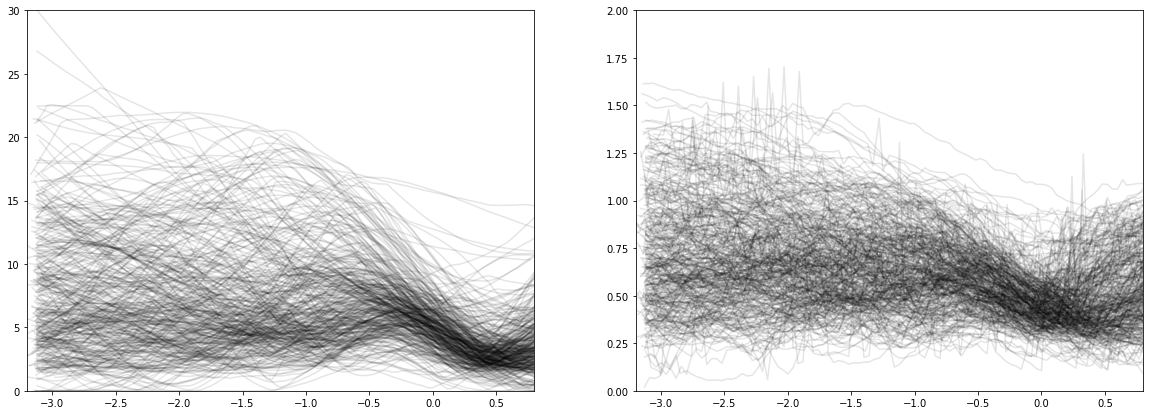

In [32]:
df_curry=df_shots.query('player_id==201939').copy()

fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(20,7))
k=0
for row in df_curry.itertuples():
    Time=getattr(row,'Time')
    D=getattr(row,'D')
    T=getattr(row,'T')
    ax1.plot(Time,D,'k-',alpha=0.1)
    ax2.plot(Time,T,'k-',alpha=0.1)
    k+=1
    
    
ax1.set_xlim((-3.2,0.8))
ax1.set_ylim((0,30))
ax2.set_xlim((-3.2,0.8))
ax2.set_ylim((0,2))

(0, 30)

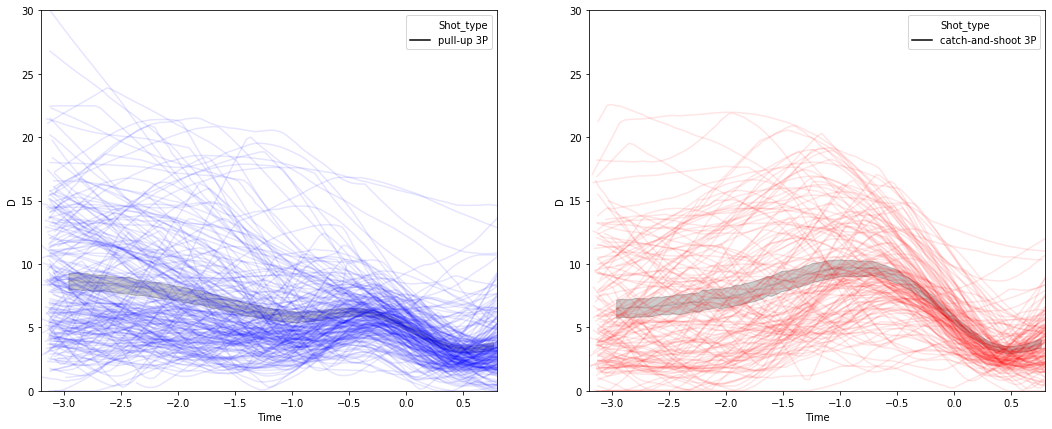

In [113]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(18,7))
df_curry_pull_up=df_shots.query('player_id==201939 and Shot_type=="pull-up 3P"').copy()
df_curry_catch=df_shots.query('player_id==201939 and Shot_type=="catch-and-shoot 3P"').copy()
for row in df_curry_pull_up.itertuples():
    Time=getattr(row,'Time')
    D=getattr(row,'D')
    T=getattr(row,'T')
    ax1.plot(Time,D,'b-',alpha=0.1)
    #ax2.plot(Time,T,'b-',alpha=0.1)
    k+=1
    
for row in df_curry_catch.itertuples():
    Time=getattr(row,'Time')
    D=getattr(row,'D')
    T=getattr(row,'T')
    ax2.plot(Time,D,'r-',alpha=0.1)
    #ax2.plot(Time,T,'r-',alpha=0.1)

sns.lineplot(x="Time", y='D', data=df_curry_mean[df_curry_mean['Shot_type']=="pull-up 3P"],hue='Shot_type',palette=['black'],ax=ax1,size_order=[60])
ax1.set_xlim((-3.2,0.8))
ax1.set_ylim((0,30))
sns.lineplot(x="Time", y='D', data=df_curry_mean[df_curry_mean['Shot_type']=="catch-and-shoot 3P"],hue='Shot_type',palette=['black'],ax=ax2,size_order=[60])
ax2.set_xlim((-3.2,0.8))
ax2.set_ylim((0,30))

397 1 295.28 201939


(0, 2)

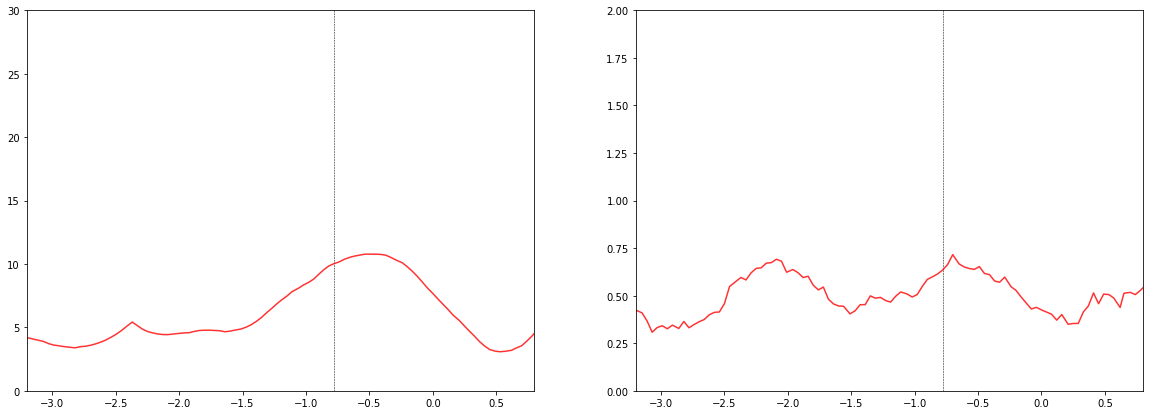

In [36]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(20,7))

#for row in df_curry_pull_up.iloc[:3].itertuples():
#    Time=getattr(row,'Time')
#    D=getattr(row,'D')
#    T=getattr(row,'T')
#   tts=getattr(row,'Time_to_shoot')[0]
#    ax1.axvline(tts, color='b',linestyle="dashed",lw=0.5)
#    ax2.axvline(tts, color='b',linestyle="dashed",lw=0.5)
#    ax1.plot(Time,D,'b-',alpha=0.8)
#    ax2.plot(Time,T,'b-',alpha=0.8)
    
for row in df_curry_catch.iloc[100:101].itertuples():
    Time=getattr(row,'Time')
    D=getattr(row,'D')
    T=getattr(row,'T')
    tts=getattr(row,'release_time')
    print(getattr(row,'Match_id'),getattr(row,'quarter'),getattr(row,'clock'),getattr(row,'player_id'))
    ax1.axvline(tts, color='black',linestyle="dashed",lw=0.5)
    ax2.axvline(tts, color='black',linestyle="dashed",lw=0.5)
    ax1.plot(Time,D,'r-',alpha=0.8)
    ax2.plot(Time,T,'r-',alpha=0.8)
    
ax1.set_xlim((-3.2,0.8))
ax1.set_ylim((0,30))
ax2.set_xlim((-3.2,0.8))
ax2.set_ylim((0,2))

### Comparing two players with high percentage

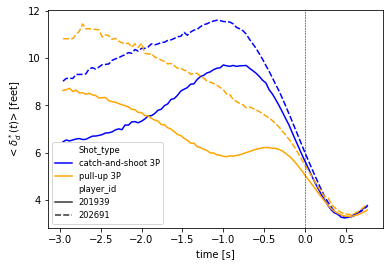

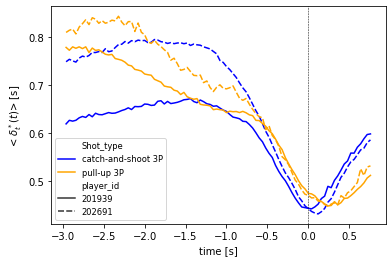

<Figure size 432x288 with 0 Axes>

In [45]:
df_other_mean=df_plot_mean.query('player_id==202691').copy()
averaged_evolution_two_df(df_other_mean,df_curry_mean,sd=None,hue='Shot_type',palette=['blue','orange'],style='player_id')

### Comparing two players : one with high and the other with low percentage

number of shots Curry: 390
percentage of CandS Curry: 0.5153846153846153
number of shots Other: 56
percentage of CandS Other: 0.9642857142857143


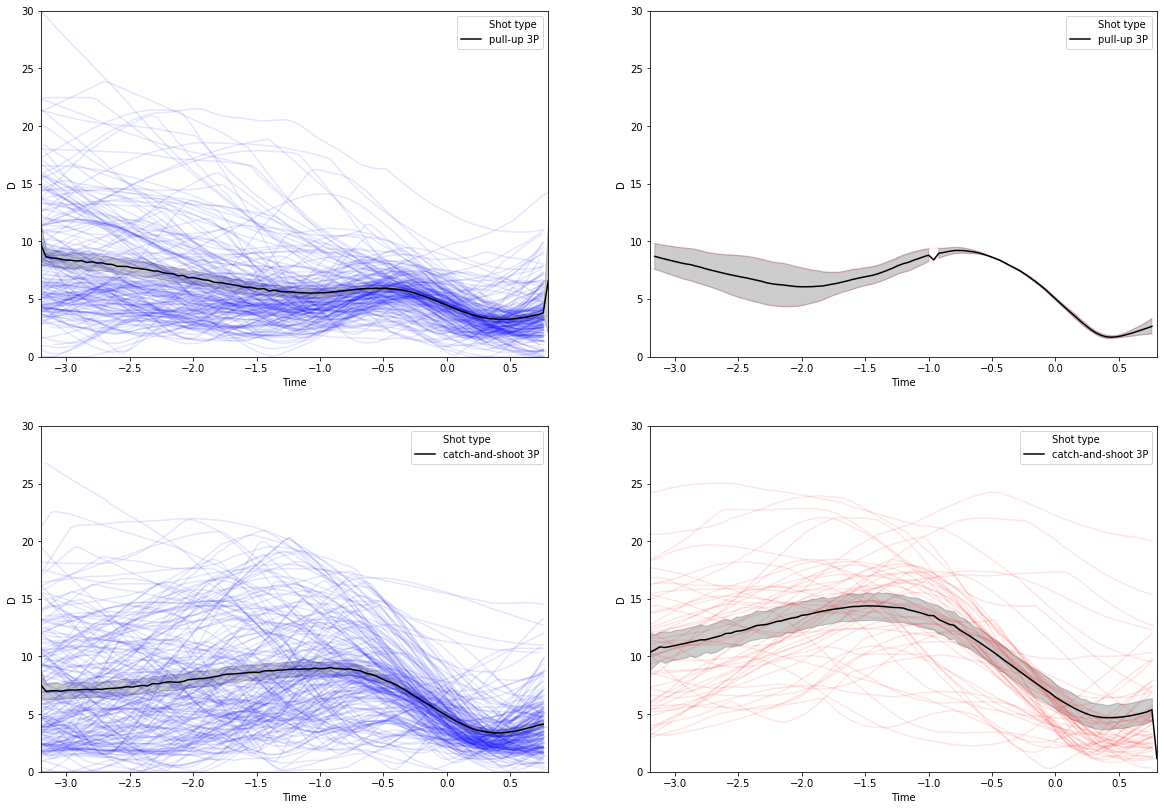

In [76]:
fig, ((ax1, ax2),(ax3,ax4)) = plt.subplots(2, 2,figsize=(20,14))
df_other_mean=df.query('player_id==202323').copy()

df_curry_pull_up=df_shots.query('player_id==201939 and Shot_type=="pull-up 3P"').copy()
df_other_pull_up=df_shots.query('player_id==202323 and Shot_type=="pull-up 3P"').copy()
df_curry_catch=df_shots.query('player_id==201939 and Shot_type=="catch-and-shoot 3P"').copy()
df_other_catch=df_shots.query('player_id==202323 and Shot_type=="catch-and-shoot 3P"').copy()

print('number of shots Curry:',len(df_curry_pull_up)+len(df_curry_catch))
print('percentage of CandS Curry:',len(df_curry_catch)/(len(df_curry_catch)+len(df_curry_pull_up)))
print('number of shots Other:',len(df_other_pull_up)+len(df_other_catch))
print('percentage of CandS Other:',len(df_other_catch)/(len(df_other_catch)+len(df_other_pull_up)))

for row in df_curry_pull_up.itertuples():
    Time=getattr(row,'Time')
    D=getattr(row,'D')
    T=getattr(row,'T')
    ax1.plot(Time,D,'b-',alpha=0.1)
    #ax3.plot(Time,T,'b-',alpha=0.1)

for row in df_curry_catch.itertuples():
    Time=getattr(row,'Time')
    D=getattr(row,'D')
    T=getattr(row,'T')
    ax3.plot(Time,D,'b-',alpha=0.1)
    #ax3.plot(Time,T,'b-',alpha=0.1)
    
for row in df_other_pull_up.itertuples():
    Time=getattr(row,'Time')
    D=getattr(row,'D')
    T=getattr(row,'T')
    ax2.plot(Time,D,'r-',alpha=0.1)
    #ax2.plot(Time,T,'r-',alpha=0.1)
    
for row in df_other_catch.itertuples():
    Time=getattr(row,'Time')
    D=getattr(row,'D')
    T=getattr(row,'T')
    ax4.plot(Time,D,'r-',alpha=0.1)
    
ax1.set_xlim((-3.2,0.8))
ax1.set_ylim((0,30))
sns.lineplot(x="Time", y='D', data=df_curry_mean[df_curry_mean['Shot type']=="pull-up 3P"],hue='Shot type',palette=['black'],ax=ax1,size_order=[60])
ax2.set_xlim((-3.2,0.8))
ax2.set_ylim((0,30))
sns.lineplot(x="Time", y='D', data=df_other_mean[df_other_mean['Shot type']=="pull-up 3P"],hue='Shot type',palette=['black'],ax=ax2,size_order=[60])
ax3.set_xlim((-3.2,0.8))
ax3.set_ylim((0,30))
sns.lineplot(x="Time", y='D', data=df_curry_mean[df_curry_mean['Shot type']=="catch-and-shoot 3P"],hue='Shot type',palette=['black'],ax=ax3,size_order=[60])
ax4.set_xlim((-3.2,0.8))
ax4.set_ylim((0,30))
sns.lineplot(x="Time", y='D', data=df_other_mean[df_other_mean['Shot type']=="catch-and-shoot 3P"],hue='Shot type',palette=['black'],ax=ax4,size_order=[60])

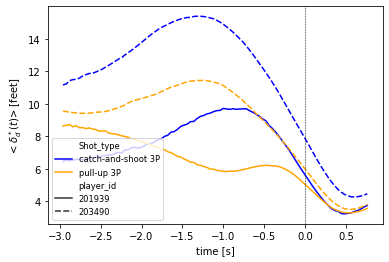

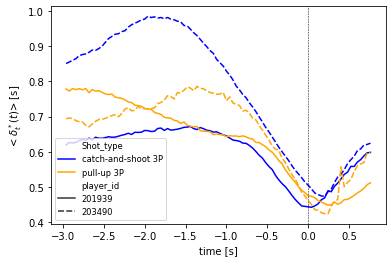

<Figure size 432x288 with 0 Axes>

In [213]:
df_other_mean=df_plot_mean.query('player_id==203490').copy()

def averaged_evolution_two_players(df_player1,df_player2,sd=None,hue=None,palette=['blue'],style=None,size=None):
    
    ## rename columns to have good labels ##
    df=pd.concat([df_player1,df_player2],ignore_index=True)
    df=df.rename(columns={"Time": "time [s]",'D':r'$<\delta_{d}^*(t)$> [feet]','T':r'$<\delta_{t}^*(t)$> [s]'})

    ### plot ###
    ax = sns.lineplot(x="time [s]", y=r'$<\delta_{d}^*(t)$> [feet]', data=df,palette=palette,ci=sd,hue=hue,style=style,size=size)
    plt.axvline(0, color='black',linestyle="dashed",lw=0.5)
    plt.legend(loc='lower left',fontsize='small')
    plt.show()
    plt.clf()
   
    ax = sns.lineplot(x="time [s]", y=r'$<\delta_{t}^*(t)$> [s]', data=df,palette=palette,ci=sd,hue=hue,style=style,size=size)
    plt.axvline(0, color='black',linestyle="dashed",lw=0.5)
    plt.legend(loc='lower left',fontsize='small')
    #plt.savefig('Comparison_curry_t',dpi=72)
    plt.show()
    plt.clf()
averaged_evolution_two_df(df_other_mean,df_curry_mean,sd=None,hue='Shot_type',palette=['blue','orange'],style='player_id')

## Link between several attributes
----
In this section we focus on the behaviour of different players by taking into account several shooting characteristics :
* d_reception is the distance of the closest defender when the shooter catches the ball
* t_reception is the time needed for the closest defender to join the shooter when the shooter catches the ball
* d_release is the distance of the closest defender at ball's release
* t_release is the time needed for the closest defender to join the shooter at ball's release
* release time is the time between the moment the player catches the ball and the moment he shots.

In [5]:
def d_reception(row):
    "Calculate distance of the closest player at ball reception"
    D=row['D']
    Time=row['Time']
    TTS=row['release_time']
    if TTS<-3:
        return(D[0])
    i=0
    while  i<len(Time) and round(Time[i],2)!=round(TTS,2):
        i+=1
    if i>=len(D):
        return D[0]
    return D[i]

def t_reception(row):
    "Calculate distance of the closest player at ball reception"
    T=row['T']
    Time=row['Time']
    TTS=row['release_time']
    if TTS<-3:
        return(T[0])
    i=0
    while  i<len(Time) and round(Time[i],2)!=round(TTS,2):
        i+=1
    if i>=len(T):
        return T[0]
    return T[i]

def d_release(row):
    "Calculate distance of the closest player at ball release"
    D=row['D']
    Time=row['Time']
    ind=Time.index(0.)
    return D[ind]

def t_release(row):
    "Calculate distance of the closest player at ball release"
    T=row['T']
    Time=row['Time']
    ind=Time.index(0.)
    return T[ind]

df_shots['d_release']=df_shots.apply(d_release,axis=1)
df_shots['t_release']=df_shots.apply(t_release,axis=1)

df_shots['d_reception']=df_shots.apply(d_reception,axis=1)
df_shots['t_reception']=df_shots.apply(t_reception,axis=1)

### Is there a link between free space at catch time and release time ? 

First let's plot release_time as a function of distance to the closest defender at catch time

R-squared: 0.007854


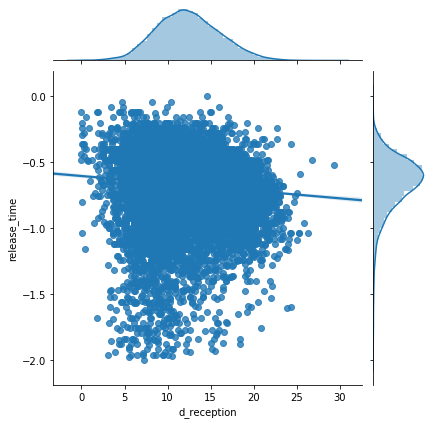

In [11]:
from scipy import stats
x=df_shots.query('Shot_type=="catch-and-shoot 3P" and d_reception<30')['d_reception']
y=df_shots.query('Shot_type=="catch-and-shoot 3P" and d_reception<30')['release_time']
g=sns.jointplot(x='d_reception',y='release_time', data=df_shots.query('Shot_type=="catch-and-shoot 3P" and d_reception<30'),kind='reg')
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
print("R-squared: %f" % r_value**2)

Over all shots, it seems that there is not a concrete dependance.

Let's plot release_time as a function of t_reception to see if it comes from the way we evaluate free space at catch time

R-squared: 0.083501


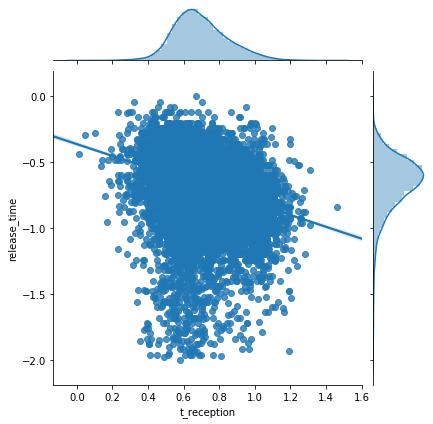

In [12]:
x=df_shots.query('Shot_type=="catch-and-shoot 3P" and d_reception<30')['t_reception']
y=df_shots.query('Shot_type=="catch-and-shoot 3P" and d_reception<30')['release_time']
g=sns.jointplot(x='t_reception',y='release_time', data=df_shots.query('Shot_type=="catch-and-shoot 3P" and d_reception<30'),kind='reg')
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
print("R-squared: %f" % r_value**2)

Here again, there is no clear correlation, although a trend seems to be emerging: the freer a player is when he receives the ball, the longer it takes him to shoot.

Actually, we cannot distinguish a clear trend over all shots because it can depends on the players : some of them can adapt their release to the free space they have while others don't. We have to evaluate individual behaviors. Let's select 16 different catch-and-shoot shooters. The selection is done the following way : 
* only players with more than 100 catch-and-shoot shots
* we select top shooters (high shooting percentage) but also poorers one to see if there is a difference between good and less good shooters

In [21]:
def players_name(row):
    return(info_players.loc[row.name]['lastName'])
df_stats['name']=df_stats.apply(players_name,axis=1)
df_stats.query('total_cas>100').sort_values(by='percentage_cas',ascending=False)

total  success  miss  percentage  match_played  total_cas  \
200755    164       77    87        47.0            34        109   
202695    128       66    62        51.6            39        103   
200768    260      106   154        40.8            41        130   
202691    272      119   153        43.8            40        223   
203114    162       67    95        41.4            43        133   
...       ...      ...   ...         ...           ...        ...   
202329    160       51   109        31.9            44        139   
977       220       54   166        24.5            36        128   
1718      123       34    89        27.6            35        111   
201143    113       31    82        27.4            41        109   
203490    122       34    88        27.9            34        113   

        success_cas  miss_cas  percentage_cas       name  
200755           60        49            55.0     Redick  
202695           56        47            54.4    Leonard  
200768           62        68            47.7      Lowry  
202691          101       122            45.3   Thompson  
203114           59        74            44.4  Middleton  
...             ...       ...             ...        ...  
202329           43        96            30.9      Aminu  
977              37        91            28.9     Bryant  
1718             32        79            28.8     Pierce  
201143           31        78            28.4    Horford  
203490           32        81            28.3     Porter  

[63 rows x 10 columns]

In [23]:
players=[203490,2594,977,201569,202325,101123,1626156,101141,1717,202695,200755,202691,201939,200768,201142,202083]
print(df_stats.loc[players].sort_values('percentage_cas',ascending=False))
players=df_stats.loc[players].sort_values('percentage_cas',ascending=False).index.tolist()

         total  success  miss  percentage  match_played  total_cas  \
200755     164       77    87        47.0            34        109   
202695     128       66    62        51.6            39        103   
200768     260      106   154        40.8            41        130   
202691     272      119   153        43.8            40        223   
201939     381      156   225        40.9            40        152   
1717       149       63    86        42.3            38        141   
201142     190       70   120        36.8            37        106   
101141     164       60   104        36.6            41        135   
2594       174       64   110        36.8            40        143   
202083     227       77   150        33.9            39        175   
201569     236       89   147        37.7            40        177   
101123     133       45    88        33.8            36        110   
1626156    176       53   123        30.1            40        109   
202325     122      

-------------
Redick
slope: 0.117224
R-squared: 0.012955
std: 0.098919
-------------
Leonard
slope: 0.750430
R-squared: 0.159658
std: 0.171310
-------------
Lowry
slope: 0.089417
R-squared: 0.003455
std: 0.134231
-------------
Thompson
slope: 0.482812
R-squared: 0.193927
std: 0.066214
-------------
Curry
slope: 0.407410
R-squared: 0.057910
std: 0.134170
-------------
Nowitzki
slope: 0.536277
R-squared: 0.176360
std: 0.098299
-------------
Durant
slope: 0.195517
R-squared: 0.017644
std: 0.143054
-------------
Ilyasova
slope: 0.627584
R-squared: 0.124289
std: 0.144448
-------------
Korver
slope: -0.037028
R-squared: 0.001418
std: 0.082744
-------------
Matthews
slope: 0.348335
R-squared: 0.110478
std: 0.075147
-------------
Gordon
slope: 0.531407
R-squared: 0.102029
std: 0.119173
-------------
Green
slope: 0.276092
R-squared: 0.048502
std: 0.117671
-------------
Russell
slope: 0.212137
R-squared: 0.015656
std: 0.162616
-------------
Johnson
slope: 0.419377
R-squared: 0.046075
std: 0.1871

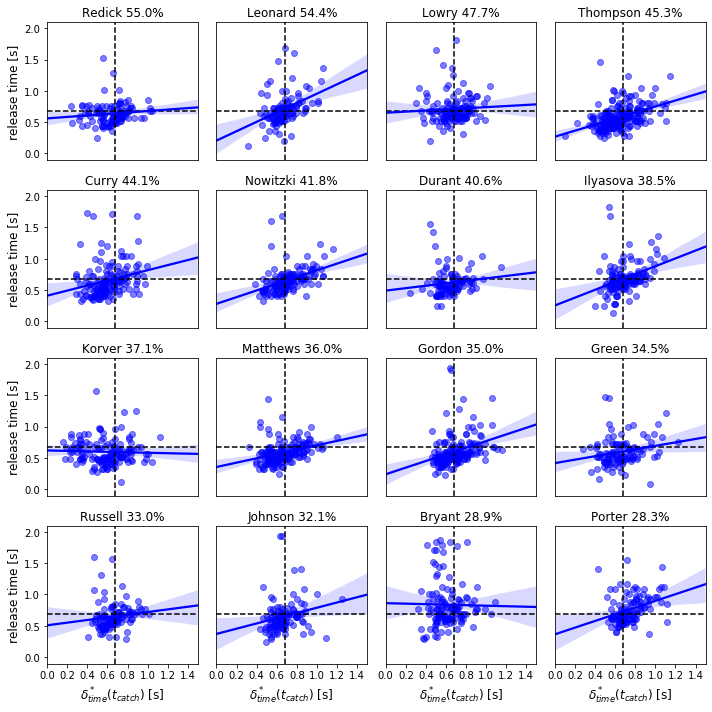

In [25]:
fig,axs=plt.subplots(4,4,sharex=True,sharey=True,figsize=(10,10))

for k in range(len(players)):
    p=players[k]
    ax=axs[k//4][k%4]
    ax.set_xlim((0,1.5))
    ax.axhline(0.68,color='k',linestyle='--')
    ax.axvline(0.68,color='k',linestyle='--')
    ax.set_xticks([0,0.2,0.4,0.6,0.8,1,1.2,1.4])
    #ax.plot([0, 1], [0, 1], transform=ax.transAxes,color='k',linestyle='--')
    df=df_shots.query('Shot_type=="catch-and-shoot 3P" and player_id==@p and btpl==True')
    #hb=ax.hexbin(df['d_reception'],df['d_release'],cmap='Blues',gridsize=50)
    #ax.scatter(df['d_reception'],df['d_release'],alpha=0.9)
    kd=sns.regplot(df['t_reception'],-df['release_time'],ax=ax,color='blue',scatter_kws={'alpha':0.5})
    if k%4==0:
        if k//4!=3:
            ax.xaxis.set_visible(False)
            ax.set_ylabel('release time [s]',fontsize='large')
        else:
            ax.set_xlabel(r'$\delta_{time}^*(t_{catch})$ [s]',fontsize='large')
            ax.set_ylabel('release time [s]',fontsize='large')
    else :
        if k//4!=3:
            ax.xaxis.set_visible(False)
            ax.yaxis.set_visible(False)
        else :
            ax.yaxis.set_visible(False)
            ax.set_xlabel(r'$\delta_{time}^*(t_{catch})$ [s]',fontsize='large')
    ax.set_title(info_players.loc[p]['lastName']+' '+str(df_stats.loc[p]['percentage_cas'])+'%')
    x=df['t_reception']
    y=-df['release_time']
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    print('-------------')
    print(info_players.loc[p]['lastName'])
    print("slope: %f" % slope)
    print("R-squared: %f" % r_value**2)
    print("std: %f" % std_err)

    
    
plt.tight_layout()
#plt.savefig('images/t_recep_release.jpg',dpi=300)

We observe that Korver does not seem to adapt his release time to the free space he has at catch time, while Matthews, Nowitzki or Thompson clearly take more time if they are more free when they catch the ball. 
Moreover, this figure reveals that players like Porter or Russell only shoot if $\delta_{time}^*(t_{catch})$ is superior to 0.5s while Curry or Korver take shots even if they are closely guarded. Finally, let’s note that Kobe Bryant’s release time can be really high even if his free space at catch time is low. This represents the
fact that he shoots even when a defender is very close to him.

Let's differentiate hits (blues) and miss (reds).

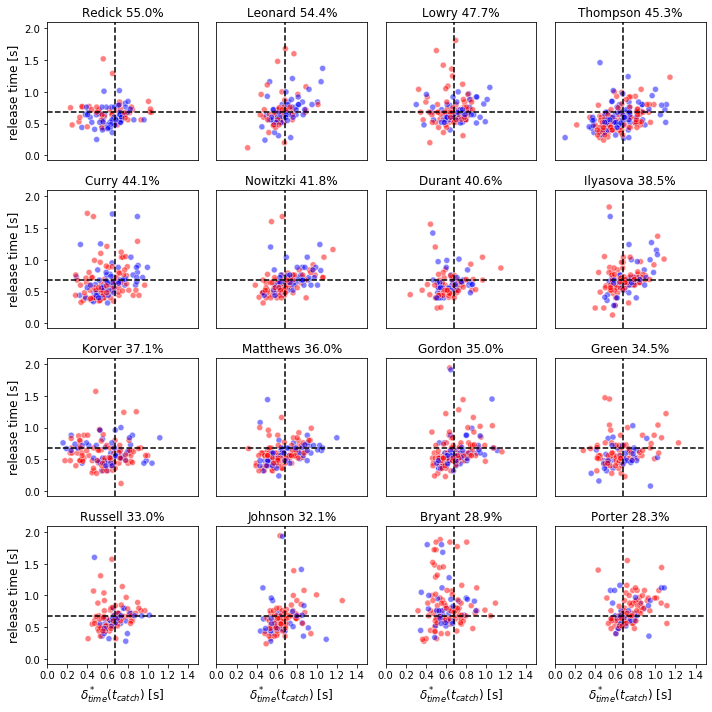

In [35]:
fig,axs=plt.subplots(4,4,sharex=True,sharey=True,figsize=(10,10))
#players=[203490,2594,977,201569,202325,101123,1626156,101141,1717,202695,200755,202691,201939,200768,201142,202083]
#axs=[axs[0][0],axs[0][1],axs[0][2],axs[1][0],axs[1][1],axs[1][2],axs[2][0],axs[2][1],axs[2][2]]
for k in range(len(players)):
    p=players[k]
    ax=axs[k//4][k%4]
    ax.set_xlim((0,1.5))
    ax.axhline(0.68,color='k',linestyle='--')
    ax.axvline(0.68,color='k',linestyle='--')
    ax.set_xticks([0,0.2,0.4,0.6,0.8,1,1.2,1.4])
    #ax.plot([0, 1], [0, 1], transform=ax.transAxes,color='k',linestyle='--')
    df=df_shots.query('Shot_type=="catch-and-shoot 3P" and player_id==@p and btpl==True')
    #hb=ax.hexbin(df['d_reception'],df['d_release'],cmap='Blues',gridsize=50)
    #ax.scatter(df['d_reception'],df['d_release'],alpha=0.9)
    sc=sns.scatterplot(df['t_reception'],-df['release_time'],ax=ax,alpha=0.5,hue=df['Shot_result'],palette=['red','blue'],legend=False)

    if k%4==0:
        if k//4!=3:
            ax.xaxis.set_visible(False)
            ax.set_ylabel('release time [s]',fontsize='large')
        else:
            ax.set_xlabel(r'$\delta_{time}^*(t_{catch})$ [s]',fontsize='large')
            ax.set_ylabel('release time [s]',fontsize='large')
    else :
        if k//4!=3:
            ax.xaxis.set_visible(False)
            ax.yaxis.set_visible(False)
        else :
            ax.yaxis.set_visible(False)
            ax.set_xlabel(r'$\delta_{time}^*(t_{catch})$ [s]',fontsize='large')
    ax.set_title(info_players.loc[p]['lastName']+' '+str(df_stats.loc[p]['percentage_cas'])+'%')
    
    
plt.tight_layout()
#plt.savefig('images/d_recep_release.jpg',dpi=300)

### How free space decreases between catch time and shot time ?
Let's plot d_release as a function of d_reception

-------------
slope: 0.580443
R-squared: 0.481513
std: 0.004380


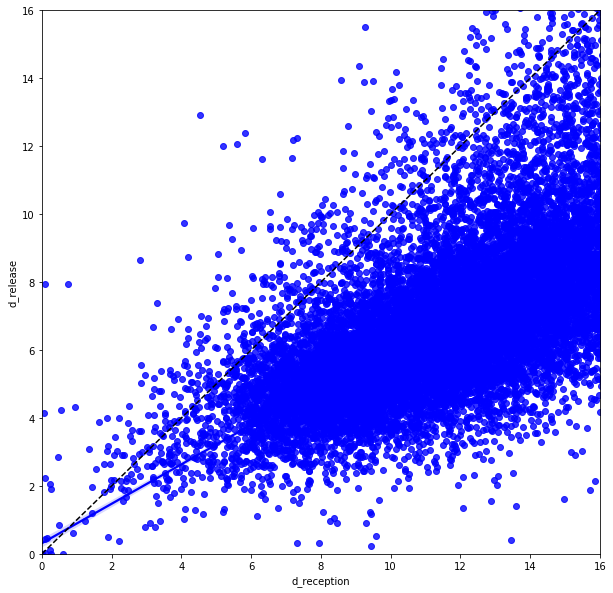

In [71]:
fig,ax=plt.subplots(figsize=(10,10))
df=df_shots.query('Shot_type=="catch-and-shoot 3P" and btpl==True')
kd=sns.regplot(df['d_reception'],df['d_release'],ax=ax,color='blue')
ax.set_xlim((0,16))
ax.set_ylim((0,16))
ax.plot([0, 1], [0, 1], transform=ax.transAxes,color='k',linestyle='--')
x=df['d_reception']
y=df['d_release']
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
print('-------------')
print("slope: %f" % slope)
print("R-squared: %f" % r_value**2)
print("std: %f" % std_err)

Obviously, the distance to closest defender at catch time is correlated with the distance at shot time : On average the distance is multiplied by 0.58.

What is interesting is to see if individual study reveals particular behavior.

-------------
Redick
slope: 0.434861
R-squared: 0.478468
std: 0.043891
-------------
Leonard
slope: 0.445570
R-squared: 0.375949
std: 0.057122
-------------
Lowry
slope: 0.444620
R-squared: 0.438243
std: 0.044494
-------------
Thompson
slope: 0.538955
R-squared: 0.497633
std: 0.036426
-------------
Curry
slope: 0.462834
R-squared: 0.551066
std: 0.034109
-------------
Nowitzki
slope: 0.585117
R-squared: 0.380361
std: 0.063344
-------------
Durant
slope: 0.401255
R-squared: 0.418193
std: 0.046409
-------------
Ilyasova
slope: 0.549451
R-squared: 0.421724
std: 0.055790
-------------
Korver
slope: 0.537645
R-squared: 0.690200
std: 0.030335
-------------
Matthews
slope: 0.745370
R-squared: 0.621884
std: 0.044188
-------------
Gordon
slope: 0.620110
R-squared: 0.546259
std: 0.042722
-------------
Green
slope: 0.777512
R-squared: 0.639487
std: 0.056175
-------------
Russell
slope: 0.438680
R-squared: 0.290152
std: 0.066333
-------------
Johnson
slope: 0.528933
R-squared: 0.465077
std: 0.05562

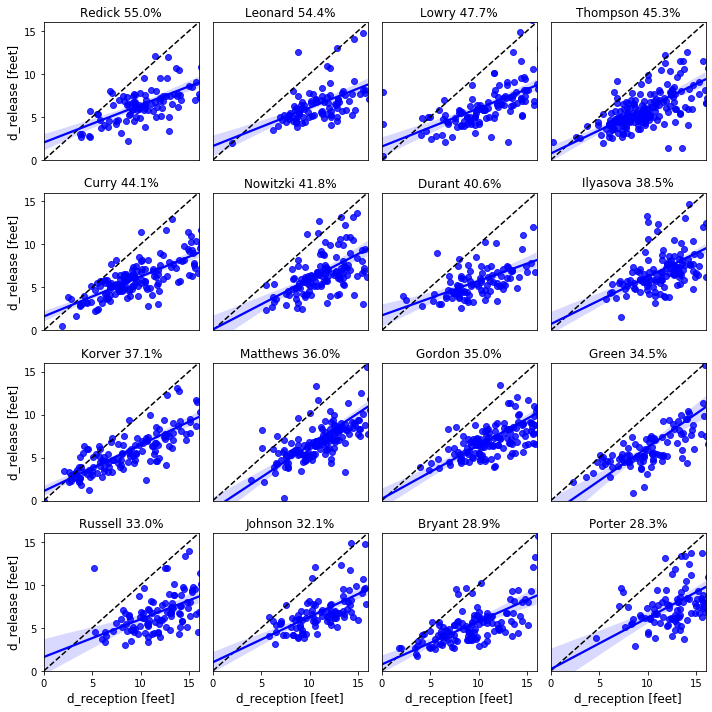

In [73]:
fig,axs=plt.subplots(4,4,sharex=True,sharey=True,figsize=(10,10))

for k in range(len(players)):
    p=players[k]
    ax=axs[k//4][k%4]
    
    ax.set_xlim((0,16))
    ax.set_ylim((0,16))
    ax.plot([0, 1], [0, 1], transform=ax.transAxes,color='k',linestyle='--')

    df=df_shots.query('Shot_type=="catch-and-shoot 3P" and player_id==@p and btpl==True')

    kd=sns.regplot(df['d_reception'],df['d_release'],ax=ax,color='blue')
    if k%4==0:
        if k//4!=3:
            ax.xaxis.set_visible(False)
            ax.set_ylabel('d_release [feet]',fontsize='large')
        else:
            ax.set_xlabel('d_reception [feet]',fontsize='large')
            ax.set_ylabel('d_release [feet]',fontsize='large')
    else :
        if k//4!=3:
            ax.xaxis.set_visible(False)
            ax.yaxis.set_visible(False)
        else :
            ax.yaxis.set_visible(False)
            ax.set_xlabel('d_reception [feet]',fontsize='large')
    ax.set_title(info_players.loc[p]['lastName']+' '+str(df_stats.loc[p]['percentage_cas'])+'%')
    x=df['d_reception']
    y=df['d_release']
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    print('-------------')
    print(info_players.loc[p]['lastName'])
    print("slope: %f" % slope)
    print("R-squared: %f" % r_value**2)
    print("std: %f" % std_err)
    
plt.tight_layout()

We observe that distance to the closest defender decreases more or less depending on the players.

### Open or Closed C&S shots ? Short or long release time ?

Vertical dashed line shows median release time while horizontal dashed lines delimit degrees of a shot
opening: very tight, tight, open and wide open above the thickest dashed line. Hits and miss are respectively associated with blue and red dots.

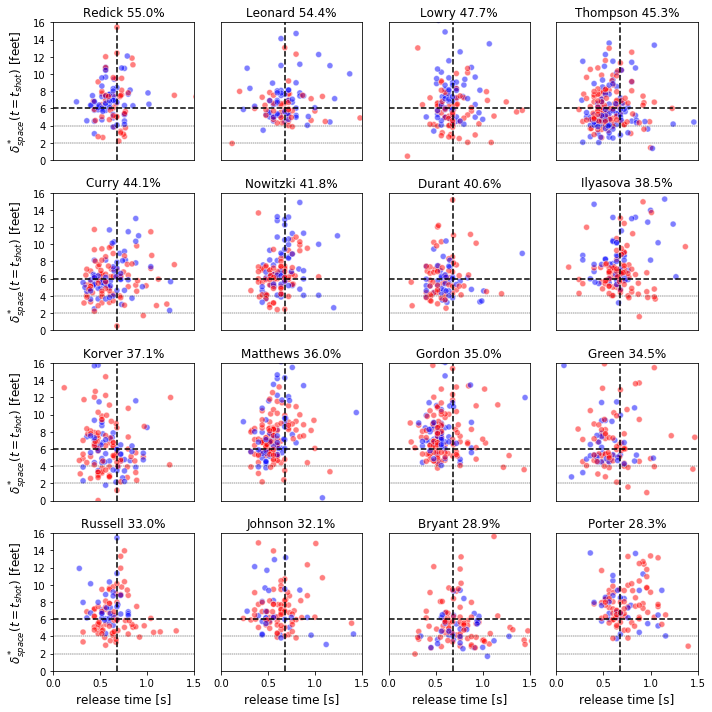

In [75]:
fig,axs=plt.subplots(4,4,sharex=True,sharey=True,figsize=(10,10))
#players=[203490,2594,977,201569,202325,101123,1626156,101141,1717,202695,200755,202691,201939,200768,201142,202083]
#axs=[axs[0][0],axs[0][1],axs[0][2],axs[1][0],axs[1][1],axs[1][2],axs[2][0],axs[2][1],axs[2][2]]
for k in range(len(players)):
    p=players[k]
    ax=axs[k//4][k%4]
    ax.set_xlim((0,1.5))
    ax.set_ylim((0,16))
    ax.axhline(2,color='k',linestyle='--',linewidth=0.4)
    ax.axhline(4,color='k',linestyle='--',linewidth=0.4)
    ax.axhline(6,color='k',linestyle='--')
    ax.axvline(0.68,color='k',linestyle='--')
    ax.set_yticks([0,2,4,6,8,10,12,14,16,18,20])
    #ax.plot([0, 1], [0, 1], transform=ax.transAxes,color='k',linestyle='--')
    df=df_shots.query('Shot_type=="catch-and-shoot 3P" and player_id==@p and btpl==True')
    #kd=sns.kdeplot(-df['release_time'],df['d_release'],ax=ax,n_levels=12)
    sc=sns.scatterplot(-df['release_time'],df['d_release'],ax=ax,alpha=0.5,hue=df['Shot_result'],palette=['red','blue'],legend=False)
    #kd=sns.regplot(-df['release_time'],df['d_release'],ax=ax,color='blue')
    #hb=ax.hexbin(-df['release_time'],df['d_release'],cmap='Blues',gridsize=10)
    if k%4==0:
        if k//4!=3:
            ax.xaxis.set_visible(False)
            ax.set_ylabel(r'$\delta_{space}^*(t=t_{shot})$ [feet]',fontsize='large')
        else:
            ax.set_xlabel('release time [s]',fontsize='large')
            ax.set_ylabel(r'$\delta_{space}^*(t=t_{shot})$ [feet]',fontsize='large')
    else :
        if k//4!=3:
            ax.xaxis.set_visible(False)
            ax.yaxis.set_visible(False)
        else :
            ax.yaxis.set_visible(False)
            ax.set_ylim((0,16))
            ax.set_xlabel('release time [s]',fontsize='large')
    ax.set_title(info_players.loc[p]['lastName']+' '+str(df_stats.loc[p]['percentage_cas'])+'%')
    
    
plt.tight_layout()
#plt.savefig('images/d_recep_release.jpg',dpi=300)

Ilyasova, Gordon, Johnson, and Leonard only take open shots.

Players with a success rate higher than 40% globally shoot quicker than the median.

Thompson's attempts can be very tight or wide-open for the same release time while Leonard mainly takes shots when the nearest defender is 4 to 8 feet away from him.

Most of Bryant’s shots are taken with the player closer than 6 feet.

In [203]:
print(df_shots.query('Shot_type=="catch-and-shoot 3P"')['release_time'].median())
print(df_shots.query('Shot_type=="catch-and-shoot 3P"')['t_reception'].median())
df_shots.query('Shot_type=="catch-and-shoot 3P"')['d_release'].median()

-0.6800000000000114
0.6773187746076399


6.3601167897351925

## Plot distance closest defender
----

In [29]:
def opp_position_release(row):
    Time=row['Time']
    ind=Time.index(0.)
    return(row['opp_pos'][ind])

def player_position_release(row):
    Time=row['Time']
    ind=Time.index(0.)
    return(row['shooter_pos'][ind])

df_shots['opp_position_release']=df_shots.apply(opp_position_release,axis=1)
df_shots['player_position_release']=df_shots.apply(player_position_release,axis=1)

In [40]:
def distance(a,b):      #a = (x,y) point de départ ; b = (i,j) point d'arrivée ; v = norme pour l'instant
    return np.sqrt((a[0]-b[0])**2+(a[1]-b[1])**2)
def behind_three_point_line(row):
    p=row['player_position_release']
    x_ball=row['x_ball']
    if x_ball[-1]>94/2:
        where=0
    else :
        where=1
    coin=False
    if where==1 :
        basket_pos=[5.25,25]
        if p[0]<15:
            coin=True
    else :
        basket_pos=[94-5.25,25]
        if p[0]>(94-15):
            coin=True
    if coin : 
        if 0<p[1]<3.5 or 50-3.5<p[1]<50 : 
            return (True)
        else :
            return (False)
    else :
        if distance(p,basket_pos)>23.5 :  #In fact 23.75 but we take a marge to have all shoots
            return (True)
        else:
            return (False)
        
df_shots['btpl']=df_shots.apply(behind_three_point_line,axis=1)
    

(0.0, 50.0, 0.0, 50.0)

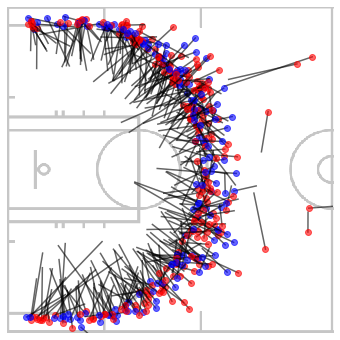

In [41]:
fig,ax=plt.subplots(1,1,figsize=(6,6))
df=df_shots.query('player_id==201939 and btpl==True')
for i in range(len(df)):
    x1=df.iloc[i]['player_position_release'][0]
    x2=df.iloc[i]['opp_position_release'][0]
    y1=50-df.iloc[i]['player_position_release'][1]
    y2=50-df.iloc[i]['opp_position_release'][1]
    if x1>94/2:
        x1=94-x1
        x2=94-x2
        y1=50-y1
        y2=50-y2
    
    if i!=len(df)-1:
        plt.plot([x1,x2],[y1,y2],'k',alpha=0.6)
        if df.iloc[i]['Shot_result']==1:
            plt.plot(x1,y1,'bo',alpha=0.6)
        else:
            plt.plot(x1,y1,'ro',alpha=0.6)
    else :
        plt.plot([x1,x2],[y1,y2],'k',alpha=0.6,label='distance closest defender')
        if df.iloc[i]['Shot_result']==1:
            plt.plot(x1,y1,'bo',alpha=0.6,label='success')
        else:
            plt.plot(x1,y1,'ro',alpha=0.6,label='miss')
        
        
#plt.legend()
field = plt.imread("Images/fullcourt1.png")
plt.imshow(field, extent=[0,50,0,50])
plt.axis('off')

## Study of ball trajectory
-----


In [57]:
def distance_to_basket(row): 
    z_ball=row['z_ball']
    x_ball=row['x_ball']
    y_ball=row['y_ball']
    
    if x_ball[-1]>94//2:
        basket_pos=[94-5.25,25]
    else :
        basket_pos=[5.25,25]
    
    d_basket=[]
    for k in range(len(x_ball)):
        d_basket.append(-np.sqrt((x_ball[k]-basket_pos[0])**2+(y_ball[k]-basket_pos[1])**2))
    
    return(d_basket)

def shoot_traj(df_traj,i):

    z_ball=df_traj.query('shot_id==@i')['z_ball'].iloc[0]
    d_basket=df_traj.query('shot_id==@i')['d_basket'].iloc[0]
        
    fig,(ax1,ax2)=plt.subplots(1,2,figsize=(15,5))
    ax1.plot(df_traj.query('shot_id==@i')['Time'].iloc[0],z_ball)
    ax2.plot(df_traj.query('shot_id==@i')['d_basket'].iloc[0],z_ball)
    #plt.axvline(-22, color='black',linestyle="dashed",lw=0.5)
    #plt.axvline(-23.75, color='black',linestyle="dashed",lw=0.5)
    #ax1.set_ylim((0,100))
    plt.show()

df_shots['d_basket']=df_shots.apply(distance_to_basket,axis=1) 

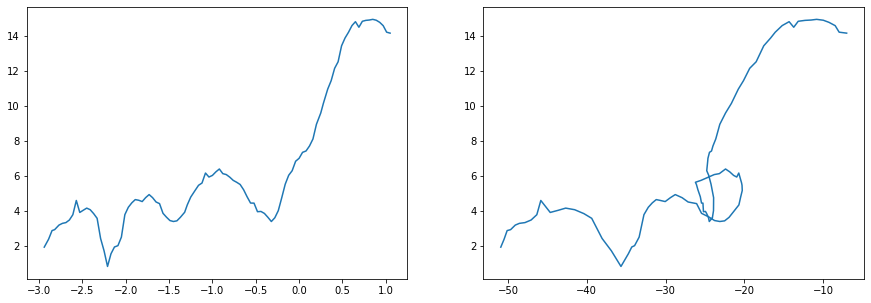

In [58]:
shoot_traj(df_shots,401)

In [59]:
def z_angle(row):
    z_ball=row['z_ball']
    d_basket=row['d_basket']
    angle=[]
    for k in range(len(d_basket)-1):
        z1=z_ball[k]
        z2=z_ball[k+1]
        d1=d_basket[k]
        d2=d_basket[k+1]
        if (d2-d1)<=0:
            angle.append(np.degrees(np.arctan((z2-z1)/(d2-d1)))+180)
        else :
            if (z2-z1)<=0:
                angle.append(np.degrees(np.arctan((z2-z1)/(d2-d1)))+360)
            else:
                angle.append(np.degrees(np.arctan((z2-z1)/(d2-d1))))
    return(angle)
 
df_shots['angle']=df_shots.apply(z_angle,axis=1)  

/Users/gabin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()


In [60]:
def traj(x, velocity, angle, h, g=9.8):
    angle = np.deg2rad(angle)
    lhs = x * np.tan(angle)
    rhs_top = g * x ** 2
    rhs_bottom = (2*(velocity)**2) * (np.cos(angle)**2)
    return h+lhs - (rhs_top / rhs_bottom)

91 15.71048
91 15.71048
90 15.82803
89 15.83377
88 15.69141
87 15.59396
86 15.20351
85 15.1447
84 14.9228
83 14.50911
82 13.71924
81 13.32854
80 12.70312
79 12.35325
78 11.70745
77 11.11343
76 10.26678
75 9.46422
74 8.84132
73 8.31762
73
48.96151388644358
62.10844545183616
22


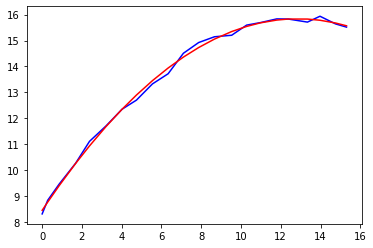

In [62]:
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import numpy as np


def test(df_traj):
    n=0
    s=11
    Time=df_traj.iloc[s]['Time']
    time_end=-1

    z_ball=df_traj.iloc[s]['z_ball']
    angle=df_traj.iloc[s]['angle']
    time_start=z_ball.index(max(z_ball))
    time_start-=1
    print(time_start,z_ball[time_start])
    while z_ball[time_start]>8.2 and (30<angle[time_start] or angle[time_start]<70):
        print(time_start,z_ball[time_start])
        time_start-=1
        
    time_start+=1
    
    time_end=z_ball.index(max(z_ball))
    time_end+=1
    while time_end<len(Time) and z_ball[time_end]>12:
        time_end+=1
    
    time_end-=1
    #while time_start<len(Time) and Time[time_start]<-1.:
    #    time_start+=1

    #while z_ball[time_start]<8.2 or (30>angle[time_start] or angle[time_start]>70):
    #    time_start+=1
        
    print(time_start)
    #time_start-=6
    #time_start=0
    z1=df_traj.iloc[s]['z_ball'][time_start:time_end]
    x1=np.array(df_traj.iloc[s]['d_basket'][time_start:time_end])
    x1=x1-x1[0]
    #print(Time[time_start])

    plt.plot(x1, z1, 'b-', label='data')
    popt, pcov = curve_fit(traj, x1, z1, p0=[19,45,8])
    plt.plot(x1, traj(x1, *popt), 'r-',
              label='fit: a=%5.3f, b=%5.3f, c=%5.3f' % tuple(popt))
    #print(df_shots.query('precise_angle_bis>70').iloc[s]['angle'][time_start])
    print(popt[1]%90)
    print(angle[time_start])
    print(len(x1))
    
test(df_shots)

## Classify shots
----

In [13]:
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import linkage

In [16]:
df_shots_catch=df_shots.query('Shot_type=="catch-and-shoot 3P"').copy()

def prepare_df_kmean_T(row):
    T=row['T']
    Time=row['Time']
    ind=Time.index(0.)
    if ind-75>0:
        if ind+20<len(T):
            
            return(np.array(T[ind-75:ind+20]))
        
    return np.nan

def prepare_df_kmean_D(row):
    D=row['D']
    Time=row['Time']
    ind=Time.index(0.)
    if ind-75>0:
        if ind+20<len(D):
            
            return(np.array(D[ind-75:ind+20]))
        
    return np.nan

df_shots_catch['D']=df_shots_catch.apply(prepare_df_kmean_D,axis=1)
df_shots_catch['T']=df_shots_catch.apply(prepare_df_kmean_T,axis=1)
#kmeans = KMeans(n_clusters=2, random_state=0).fit(df_shots['D'].values)

In [17]:
df=df_shots_catch.dropna()
D=df[['D']].values
T=df[['T']].values
Time=df[['Time']].values
D_bis=[]
T_bis=[]
print(len(D[0][0]))
print(len(T[0][0]))
for k in range(len(D)):
    D_bis.append(D[k][0])
    T_bis.append(T[k][0])
    if len(D[k][0])!=95:
        print(len(D[k]))

95
95


In [18]:
kmeans_T=KMeans(n_clusters=2).fit(T_bis)
kmeans_D=KMeans(n_clusters=2).fit(D_bis)

22887.41652327517


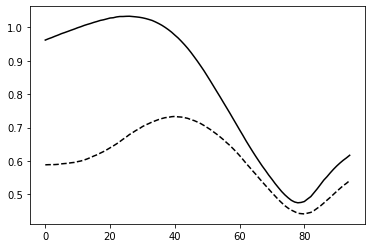

In [19]:
c_T=kmeans_T.cluster_centers_
print(kmeans_T.inertia_)
plt.plot(c_T[0],'k-')
plt.plot(c_T[1],'k--')

9286715.560567763


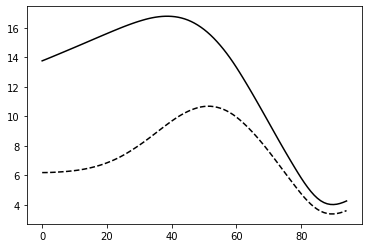

In [20]:
c_D=kmeans_D.cluster_centers_
print(kmeans_D.inertia_)
plt.plot(c_D[0],'k-')
plt.plot(c_D[1],'k--')

In [36]:
from matplotlib.cbook import get_sample_data
def kmean_ev(df,c,Time,sd=None,hue=None,palette=['blue'],style=None,fontsize='medium',size=None):
    im = plt.imread(get_sample_data('/Users/gabin/Ordinateur/Documents/CENTRALE_LYON_1A/PaR/bakset-image.png'))
    fig,ax=plt.subplots(1,1,figsize=(6,4))
    ## rename columns to have good labels ##
    df2=df.rename(columns={"Time": "time [s]",'D':r'$<\delta_{space}^*(t)$> [feet]','T':r'$<\delta_{time}^*(t)$> [s]'})
    ax = sns.lineplot(x="time [s]", y=r'$<\delta_{space}^*(t)$> [feet]', data=df2,palette=palette,ci=sd,hue=hue,style=style,size=size,label='pull-up')
    plt.plot(Time[1:-4],c[0],color='orange',linestyle='-',label='catch-and-shoot 1')
    plt.plot(Time[1:-4],c[1],color='orange',linestyle='--',label='catch-and-shoot 2')
    plt.axvline(0, color='black',linestyle="dashed",lw=0.5)
    plt.legend(loc='lower left',fontsize=fontsize)
    plt.annotate('shot time',(-0.29,12.4))
    newax = fig.add_axes([0.63, 0.65, 0.2, 0.2], anchor='NE', zorder=1)
    newax.imshow(im)
    newax.axis('off')
    #plt.savefig('/Users/gabin/Ordinateur/Documents/Images/delta_space.png',dpi=300)
    plt.show()
    plt.clf()
    
    im = plt.imread(get_sample_data('/Users/gabin/Ordinateur/Documents/CENTRALE_LYON_1A/PaR/bakset-image.png'))
    ### plot ###
    fig,ax=plt.subplots(1,1,figsize=(6,4))
    ax = sns.lineplot(x="time [s]", y=r'$<\delta_{time}^*(t)$> [s]', data=df2,palette=palette,ci=sd,hue=hue,style=style,size=size,label='pull-up')
    plt.plot(Time[1:-4],c[0],color='orange',linestyle='-',label='catch-and-shoot 1')
    plt.plot(Time[1:-4],c[1],color='orange',linestyle='--',label='catch-and-shoot 2')
    plt.axvline(0, color='black',linestyle="dashed",lw=0.5)
    plt.legend(loc='lower left',fontsize=fontsize)
    plt.annotate('shot time',(-0.29,0.84))
    newax = fig.add_axes([0.63, 0.65, 0.2, 0.2], anchor='NE', zorder=1)
    newax.imshow(im)
    newax.axis('off')
    plt.savefig('/Users/gabin/Ordinateur/Documents/Images/delta_time.png',dpi=300)
    plt.show()
    plt.clf()

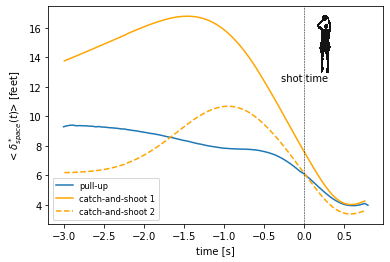

<Figure size 432x288 with 0 Axes>

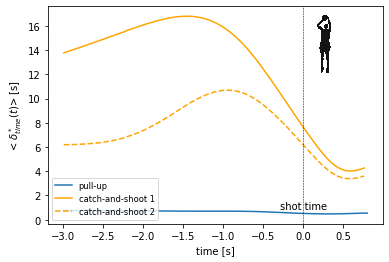

<Figure size 432x288 with 0 Axes>

In [35]:
kmean_ev(df_plot_mean.query('Shot_type=="pull-up 3P"'),c_D,Time[0][0],sd=None,hue=None,palette=['blue'],style=None,fontsize='small',size=None)

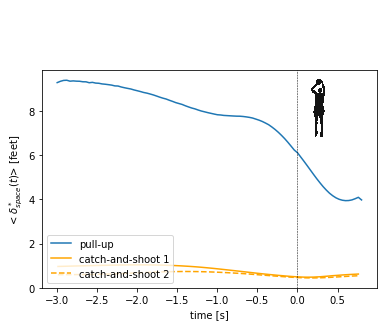

<Figure size 432x288 with 0 Axes>

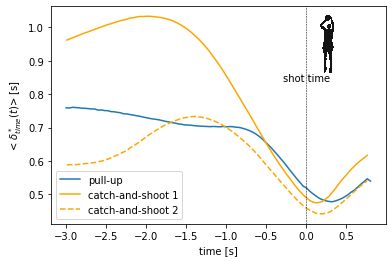

<Figure size 432x288 with 0 Axes>

In [37]:
kmean_ev(df_plot_mean.query('Shot_type=="pull-up 3P"'),c_T,Time[0][0],sd=None,hue=None,palette=['blue'],style=None,fontsize='medium',size=None)

## Free space evolution for 50 randomly chosen shots
----

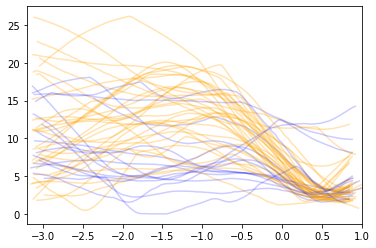

In [591]:
import random as rd
catch=[]
pull=[]
for k in range(50):
    s=rd.randint(0,17000)
    df=df_shots.iloc[s]
    if df['Shot_type']=="catch-and-shoot 3P":
        catch.append(s)
        plt.plot(df['Time'],df['D'],c='orange',alpha=0.3)
    else:
        pull.append(s)
        plt.plot(df['Time'],df['D'],c='blue',alpha=0.2)
    plt.xlim((-3.2,1))

In [559]:
def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N

(-0.5, 999.5, 999.5, -0.5)

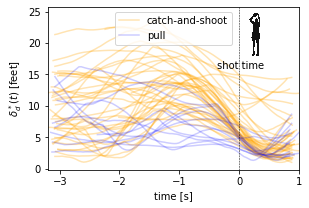

In [548]:
fig,ax=plt.subplots(1,1,figsize=(4.5,3))
for c in catch[:-1]:
    df=df_shots.iloc[c]
    plt.plot(df['Time'],df['D'],c='orange',alpha=0.3)
for c in pull[:-1]:
    df=df_shots.iloc[c]
    plt.plot(df['Time'],df['D'],c='blue',alpha=0.2)
    
df=df_shots.iloc[catch[-1]]
plt.plot(df['Time'],df['D'],c='orange',alpha=0.3,label="catch-and-shoot")
df=df_shots.iloc[pull[-1]]
plt.plot(df['Time'],df['D'],c='blue',alpha=0.2,label="pull")
plt.xlabel("time [s]")
plt.ylabel(r'$\delta_{d}^*(t)$ [feet]')
plt.legend(loc='upper center')
plt.axvline(0, color='black',linestyle="dashed",lw=0.5)  
plt.xlim((-3.2,1))
im = plt.imread(get_sample_data('/Users/gabin/Ordinateur/Documents/CENTRALE_LYON_1A/PaR/bakset-image.png'))
plt.annotate('shot time',(-0.37,16))
newax = fig.add_axes([0.63, 0.65, 0.2, 0.2], anchor='NE', zorder=1)
newax.imshow(im)
newax.axis('off')

(-0.5, 999.5, 999.5, -0.5)

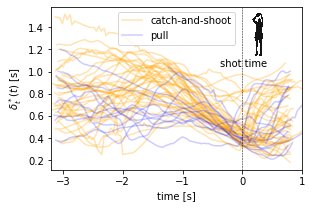

In [549]:
fig,ax=plt.subplots(1,1,figsize=(4.5,3))
for c in catch[:-1]:
    df=df_shots.iloc[c]
    T=running_mean(df['T'],3)
    plt.plot(df['Time'][:-2],T,c='orange',alpha=0.3)
for c in pull[:-1]:
    df=df_shots.iloc[c]
    T=running_mean(df['T'],3)
    plt.plot(df['Time'][:-2],T,c='blue',alpha=0.2)
df=df_shots.iloc[catch[-1]]
plt.plot(df['Time'],df['T'],c='orange',alpha=0.3,label="catch-and-shoot")
df=df_shots.iloc[pull[-1]]
plt.plot(df['Time'],df['T'],c='blue',alpha=0.2,label="pull")
plt.legend(loc='upper center')
plt.xlabel("time [s]")
plt.ylabel(r'$\delta_{t}^*(t)$ [s]')
plt.axvline(0, color='black',linestyle="dashed",lw=0.5)  
plt.xlim((-3.2,1))
im = plt.imread(get_sample_data('/Users/gabin/Ordinateur/Documents/CENTRALE_LYON_1A/PaR/bakset-image.png'))
plt.annotate('shot time',(-0.37,1.05))
newax = fig.add_axes([0.63, 0.65, 0.2, 0.2], anchor='NE', zorder=1)
newax.imshow(im)
newax.axis('off')


## *Free space* and 3P performance
------

We want to quantify the following intuition : "the more free a shooter is, the more efficient he is". To do so, we evaluate 3-point efficiency function of the distance (and time) within the opponent defender is. 

34.32047018087385


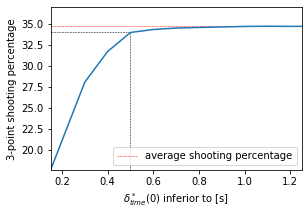

In [14]:
t_abs=[0.15]+[0.1*(i+3) for i in range(12)]
inferior_abs=[]
fig,ax=plt.subplots(1,1,figsize=(4.5,3))
for d in t_abs:
    l=[7641,14919]
    m=df_shots.query("t_release<@d and btpl==True and shot_id not in @l").groupby('Shot_result').count().loc[0,'D']
    s=df_shots.query("t_release<@d and btpl==True and shot_id not in @l").groupby('Shot_result').count().loc[1,'D']
    #print(m,s,s/(s+m))
    #print(m+s)
    inferior_abs.append(s/(s+m)*100)

plt.vlines(t_abs[3], inferior_abs[0], inferior_abs[3], linestyle="dashed",lw=0.5)
plt.hlines(inferior_abs[3], t_abs[0], t_abs[3], linestyle="dashed",lw=0.5)
plt.axhline(34.7,linestyle="dashed",lw=0.5,color='red',label='average shooting percentage')
plt.xlim((0.15,1.25))
plt.ylim((min(inferior_abs),37))
plt.xlabel(r'$\delta_{time}^*(0)$ inferior to [s]')
plt.ylabel(r'3-point shooting percentage')
plt.legend()
plt.plot(t_abs,inferior_abs)
print(inferior_abs[4])

25.965488907148725 33.121491367439894


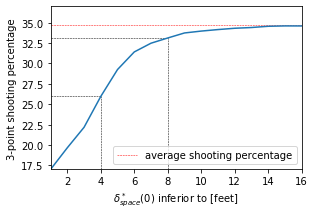

In [12]:
fig,ax=plt.subplots(1,1,figsize=(4.5,3))
d_abs=[1*(i+1) for i in range(16)]
inferior_abs=[]
for d in d_abs:
    l=[7641,14919]
    #if d==2:
    #    print(df_shots.query("1<d_release<@d and btpl==True and Shot_result==1 and shot_id not in @l")[['shot_id']])
    m=df_shots.query("d_release<@d and btpl==True and shot_id not in @l").groupby('Shot_result').count().loc[0,'D']
    s=df_shots.query("d_release<@d and btpl==True and shot_id not in @l").groupby('Shot_result').count().loc[1,'D']
    inferior_abs.append(s/(s+m)*100)

plt.vlines(d_abs[3], inferior_abs[0], inferior_abs[3], linestyle="dashed",lw=0.5)
plt.hlines(inferior_abs[3], d_abs[0], d_abs[3], linestyle="dashed",lw=0.5)
plt.vlines(d_abs[7], inferior_abs[0], inferior_abs[7], linestyle="dashed",lw=0.5)
plt.hlines(inferior_abs[7], d_abs[0], d_abs[7], linestyle="dashed",lw=0.5)
plt.axhline(34.7,linestyle="dashed",lw=0.5,color='red',label='average shooting percentage')
plt.xlim((1,16))
plt.ylim((min(inferior_abs),37))
plt.legend()
plt.xlabel(r'$\delta_{space}^*(0)$ inferior to [feet]')
plt.ylabel(r'3-point shooting percentage')
plt.plot(d_abs,inferior_abs)
print(inferior_abs[3],inferior_abs[7])